## Task1
Reimplement the feed-forward neural network from Week 2 in PyTorch, using
the same subset of the AGnews dataset – this time we have not provided any starting
point for you, so you need to create a new notebook for this. This notebook is one of
two notebooks that you need to submit for Week 3.

In [36]:
import torch
from torch import nn

from torchvision import datasets
from torchvision.transforms import ToTensor

In [37]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


## Define the Class
We define our neural network by subclassing ``nn.Module``, and
initialize the neural network layers in ``__init__``. Every ``nn.Module`` subclass implements
the operations on input data in the ``forward`` method.

In [38]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1500, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 3),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

We create an instance of ``NeuralNetwork``, and move it to the ``device``, and print
its structure.

In [39]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1500, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=3, bias=True)
  )
)


## Get Training and Test Data

In [40]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.feature_extraction.text import TfidfVectorizer

def preprocess_agnews(csv_file):
    '''Load and preprocess AG News data'''
    df = pd.read_csv(csv_file, header = None)
    df = df[df[0] !=1]
    df['label'] = df[0] - 2
    df['text'] = [" ".join((title, body)) for title, body in zip(df[1], df[2])]
    return df[['text', 'label']]

class TextDataset(Dataset):
    def __init__(self, dataframe, max_features=1500, vectoriser=None):
        self.texts = dataframe['text'].tolist()
        self.labels = dataframe['label'].tolist()
        
        # TF-IDF: fit on training, reuse for testing
        if vectoriser is None:
            # Training: create and fit
            self.vectoriser = TfidfVectorizer(max_features=max_features, stop_words='english')
            self.features = self.vectoriser.fit_transform(self.texts)
        else:
            # Testing: use provided vectoriser
            self.vectoriser = vectoriser
            self.features = self.vectoriser.transform(self.texts)
        
        # Convert sparse matrix to dense tensor (TF-IDF returns sparse)
        self.features = torch.tensor(self.features.toarray(), dtype=torch.float32)
        self.labels = torch.tensor(self.labels, dtype=torch.long)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        # Just return pre-computed vectors
        return self.features[idx], self.labels[idx]

In [41]:
train_df = preprocess_agnews('../W2_feedfoward_neural_networks/agnews_train.csv')
test_df = preprocess_agnews('../W2_feedfoward_neural_networks/agnews_test.csv')

train_dataset = TextDataset(train_df, max_features=1500)
test_dataset = TextDataset(test_df, vectoriser=train_dataset.vectoriser)  # Passing the fitted vectoriser

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Hyperparameters

Hyperparameters are adjustable parameters that let you control the model optimization process.
Different hyperparameter values can impact model training and convergence rates
([read more](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html)_ about hyperparameter tuning)

We define the following hyperparameters for training:
 - **Number of Epochs** - the number times to iterate over the dataset
 - **Batch Size** - the number of data samples propagated through the network before the parameters are updated
 - **Learning Rate** - how much to update models parameters at each batch/epoch. Smaller values yield slow learning speed, while large values may result in unpredictable behavior during training.




In [42]:
learning_rate = 0.01
batch_size = 64
epochs = 10

## Optimization Loop

Once we set our hyperparameters, we can then train and optimize our model with an optimization loop. Each
iteration of the optimization loop is called an **epoch**.

Each epoch consists of two main parts:
 - **The Train Loop** - iterate over the training dataset and try to converge to optimal parameters.
 - **The Validation/Test Loop** - iterate over the test dataset to check if model performance is improving.

Let's briefly familiarize ourselves with some of the concepts used in the training loop. Jump ahead to
see the `full-impl-label` of the optimization loop.

### Loss Function

When presented with some training data, our untrained network is likely not to give the correct
answer. **Loss function** measures the degree of dissimilarity of obtained result to the target value,
and it is the loss function that we want to minimize during training. To calculate the loss we make a
prediction using the inputs of our given data sample and compare it against the true data label value.

Common loss functions include [nn.MSELoss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss) (Mean Square Error) for regression tasks, and
[nn.NLLLoss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss) (Negative Log Likelihood) for classification.
[nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) combines ``nn.LogSoftmax`` and ``nn.NLLLoss``.

We pass our model's output logits to ``nn.CrossEntropyLoss``, which will normalize the logits and compute the prediction error.



In [43]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

### Optimizer

Optimization is the process of adjusting model parameters to reduce model error in each training step. **Optimization algorithms** define how this process is performed (in this example we use Stochastic Gradient Descent).
All optimization logic is encapsulated in  the ``optimizer`` object. Here, we use the SGD optimizer; additionally, there are many [different optimizers](https://pytorch.org/docs/stable/optim.html)
available in PyTorch such as ADAM and RMSProp, that work better for different kinds of models and data.

We initialize the optimizer by registering the model's parameters that need to be trained, and passing in the learning rate hyperparameter.

In [44]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## Implementing the model

In [45]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    total_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        total_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
    return total_loss/len(dataloader)


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return test_loss, correct

We initialize the loss function and optimizer, and pass it to ``train_loop`` and ``test_loop``.
Feel free to increase the number of epochs to track the model's improving performance.

In [46]:
train_losses = []
test_losses = []
test_accuracies = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_loader, model, loss_fn, optimizer)
    train_losses.append(train_loss)

    test_loss, accuracy = test_loop(test_loader, model, loss_fn)
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
print("Done!")

Epoch 1
-------------------------------
loss: 1.098063  [   64/90000]
loss: 1.101535  [ 6464/90000]
loss: 1.097964  [12864/90000]
loss: 1.099547  [19264/90000]
loss: 1.097465  [25664/90000]
loss: 1.096145  [32064/90000]
loss: 1.098468  [38464/90000]
loss: 1.096595  [44864/90000]
loss: 1.098864  [51264/90000]
loss: 1.097384  [57664/90000]
loss: 1.097411  [64064/90000]
loss: 1.097593  [70464/90000]
loss: 1.095108  [76864/90000]
loss: 1.094704  [83264/90000]
loss: 1.095996  [89664/90000]
Test Error: 
 Accuracy: 34.2%, Avg loss: 1.096933 

Epoch 2
-------------------------------
loss: 1.097796  [   64/90000]
loss: 1.096651  [ 6464/90000]
loss: 1.095778  [12864/90000]
loss: 1.097438  [19264/90000]
loss: 1.095381  [25664/90000]
loss: 1.096704  [32064/90000]
loss: 1.095862  [38464/90000]
loss: 1.094654  [44864/90000]
loss: 1.095283  [51264/90000]
loss: 1.095955  [57664/90000]
loss: 1.095212  [64064/90000]
loss: 1.094405  [70464/90000]
loss: 1.097030  [76864/90000]
loss: 1.095420  [83264/90000

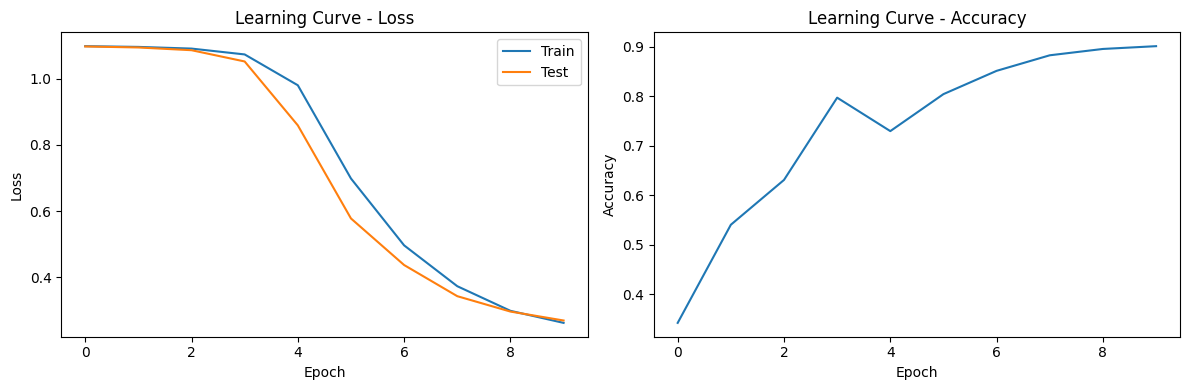

In [47]:
import matplotlib.pyplot as plt

# After training completes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss curve
ax1.plot(train_losses, label='Train')
ax1.plot(test_losses, label='Test')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Learning Curve - Loss')
ax1.legend()

# Accuracy curve
ax2.plot(test_accuracies)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Learning Curve - Accuracy')

plt.tight_layout()
plt.show()